In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [74]:
data = pd.read_csv('data_final.csv')
# Keeping only the neccessary columns
data = data[['Headline','Price movement']]

In [75]:
data = data[data['Price movement'] != "#N/A"]
data['Headline'] = data['Headline'].apply(lambda x: x.lower())
data['Headline'] = data['Headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[data['Price movement'] == 'Up'].size)
print(data[data['Price movement'] == 'Down'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['Headline'].values)
X = tokenizer.texts_to_sequences(data['Headline'].values)
X = pad_sequences(X)

4490
3724


In [76]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
import tensorflow as tf

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 32, 128)           256000    
                                                                 
 conv1d_21 (Conv1D)          (None, 32, 128)           65664     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 16, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 16, 64)            32832     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 8, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 8, 32)            

In [77]:
Y = pd.get_dummies(data['Price movement']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2844, 32) (2844, 2)
(1402, 32) (1402, 2)


In [78]:
batch_size = 32
epochs = 20
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose = 2)

Epoch 1/20
89/89 - 1s - loss: 0.6873 - accuracy: 0.5359 - precision_8: 0.5323 - recall_8: 0.4803 - 1s/epoch - 17ms/step
Epoch 2/20
89/89 - 1s - loss: 0.6351 - accuracy: 0.6329 - precision_8: 0.6361 - recall_8: 0.6143 - 642ms/epoch - 7ms/step
Epoch 3/20
89/89 - 1s - loss: 0.3839 - accuracy: 0.8245 - precision_8: 0.8233 - recall_8: 0.8230 - 709ms/epoch - 8ms/step
Epoch 4/20
89/89 - 1s - loss: 0.1915 - accuracy: 0.9314 - precision_8: 0.9243 - recall_8: 0.9334 - 639ms/epoch - 7ms/step
Epoch 5/20
89/89 - 1s - loss: 0.1191 - accuracy: 0.9560 - precision_8: 0.9512 - recall_8: 0.9585 - 698ms/epoch - 8ms/step
Epoch 6/20
89/89 - 1s - loss: 0.0828 - accuracy: 0.9698 - precision_8: 0.9655 - recall_8: 0.9792 - 732ms/epoch - 8ms/step
Epoch 7/20
89/89 - 1s - loss: 0.0661 - accuracy: 0.9666 - precision_8: 0.9698 - recall_8: 0.9811 - 636ms/epoch - 7ms/step
Epoch 8/20
89/89 - 1s - loss: 0.0511 - accuracy: 0.9722 - precision_8: 0.9782 - recall_8: 0.9811 - 713ms/epoch - 8ms/step
Epoch 9/20
89/89 - 1s - lo

In [79]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

44/44 - 1s - loss: 2.3850 - accuracy: 0.6020 - precision_8: 0.6044 - recall_8: 0.5658 - 1s/epoch - 27ms/step
Accuracy: 60.20%


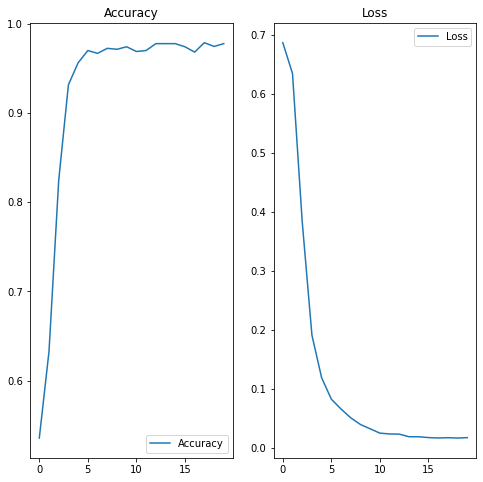

In [80]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()